In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.cbook as cbook
import datetime
import gmaps
import requests
import json
from config import gkey
gmaps.configure(api_key=gkey)

In [45]:
# Read in all data 
homeprice=pd.read_csv('Inputs/Sale_Prices_Zip.csv')
business=pd.read_csv('Inputs/Licensed_Businesses_WA.csv')
pot_sales=pd.read_csv('Inputs/Sales_and_Tax_Report_WA.csv')
us_states_hp=pd.read_csv('Inputs/Sale_Prices_State.csv')

C:\Users\mstos\AppData\Local\Continuum\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2785: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


# Plot Percent Change in Median Home Sales Price Year to Year: States vs. Total US

The following codes cleans the csv that contains median home sales price for every month starting March, 2008 for all states and the total United States, aggregates by year, and plots the percent change. 

In [46]:
us_states_hp

,RegionID,RegionName,SizeRank,2008-03,2008-04,2008-05,2008-06,2008-07,2008-08,2008-09,...,2018-02,2018-03,2018-04,2018-05,2018-06,2018-07,2018-08,2018-09,2018-10,2018-11
0,NaN,United States,0,188300.0,184700.0,180700.0,176800.0,175100.0,174200.0,173200.0,...,229400.0,232500.0,232300.0,229700.0,227600.0,226700.0,226200.0,226100.0,225900.0,NaN
1,9.0,California,1,390100.0,371500.0,347100.0,331200.0,316800.0,304600.0,290100.0,...,478800.0,483100.0,484000.0,482900.0,482900.0,485600.0,488000.0,488500.0,487900.0,486100.0
2,54.0,Texas,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,212400.0,213800.0,214700.0,214700.0,217100.0,219600.0,219700.0,217900.0,215100.0,NaN
3,43.0,New York,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,295300.0,296900.0,297400.0,299100.0,300800.0,303500.0,302600.0,302000.0,296400.0,NaN
4,14.0,Florida,4,205900.0,197200.0,190800.0,186500.0,183800.0,180500.0,175600.0,...,223200.0,226000.0,223100.0,218600.0,216600.0,216100.0,217600.0,219000.0,220300.0,NaN
5,21.0,Illinois,5,212000.0,207200.0,192900.0,183300.0,179700.0,180800.0,181900.0,...,184000.0,191000.0,193200.0,192100.0,192600.0,192900.0,190900.0,186900.0,184400.0,189600.0
6,47.0,Pennsylvania,6,147900.0,146200.0,144400.0,141000.0,140900.0,141500.0,142300.0,...,163800.0,166000.0,164400.0,163900.0,161700.0,162400.0,162400.0,162700.0,162700.0,NaN
7,44.0,Ohio,7,110300.0,106700.0,105900.0,105400.0,105900.0,105200.0,103300.0,...,141100.0,140100.0,136700.0,133600.0,133000.0,133900.0,135500.0,137100.0,138100.0,NaN
8,30.0,Michigan,8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,146300.0,147300.0,146600.0,145300.0,142000.0,141800.0,141100.0,141400.0,138700.0,NaN
9,16.0,Georgia,9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,184100.0,185800.0,187400.0,185800.0,185400.0,184300.0,183200.0,184300.0,185400.0,NaN


In [47]:
us_wa_hp=us_states_hp.loc[(us_states_hp['RegionName']== 'Washington') | (us_states_hp['RegionName']== 'Colorado') | (us_states_hp['RegionName']== 'Oregon')| (us_states_hp['RegionName']== 'United States')]

In [48]:
us_wa_hp.drop(['RegionID','SizeRank'],axis=1,inplace=True)

C:\Users\mstos\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [49]:
us_wa_hp

,RegionName,2008-03,2008-04,2008-05,2008-06,2008-07,2008-08,2008-09,2008-10,2008-11,...,2018-02,2018-03,2018-04,2018-05,2018-06,2018-07,2018-08,2018-09,2018-10,2018-11
0,United States,188300.0,184700.0,180700.0,176800.0,175100.0,174200.0,173200.0,171500.0,169300.0,...,229400.0,232500.0,232300.0,229700.0,227600.0,226700.0,226200.0,226100.0,225900.0,NaN
13,Washington,283600.0,278100.0,270000.0,262500.0,258400.0,257700.0,255800.0,254700.0,252000.0,...,345500.0,350200.0,356000.0,353300.0,350000.0,346400.0,343600.0,344100.0,345900.0,348100.0
22,Colorado,206100.0,202000.0,200000.0,198600.0,200800.0,202300.0,202100.0,199700.0,195000.0,...,349400.0,351000.0,355700.0,357200.0,355700.0,353400.0,354100.0,356100.0,357400.0,356300.0
27,Oregon,255100.0,248700.0,243200.0,241500.0,240900.0,239200.0,233800.0,232900.0,230500.0,...,325600.0,329300.0,327700.0,323500.0,323900.0,323500.0,326100.0,324500.0,325600.0,326700.0


In [50]:
us_wa_hp.set_index('RegionName',inplace=True)
us_wa_hp=us_wa_hp.transpose()
us_wa_hp.reset_index(inplace=True)
us_wa_hp[['Year','Month']]=us_wa_hp['index'].str.split('-',expand=True)
us_wa_hp

RegionName,index,United States,Washington,Colorado,Oregon,Year,Month
0,2008-03,188300.0,283600.0,206100.0,255100.0,2008,03
1,2008-04,184700.0,278100.0,202000.0,248700.0,2008,04
2,2008-05,180700.0,270000.0,200000.0,243200.0,2008,05
3,2008-06,176800.0,262500.0,198600.0,241500.0,2008,06
4,2008-07,175100.0,258400.0,200800.0,240900.0,2008,07
5,2008-08,174200.0,257700.0,202300.0,239200.0,2008,08
6,2008-09,173200.0,255800.0,202100.0,233800.0,2008,09
7,2008-10,171500.0,254700.0,199700.0,232900.0,2008,10
8,2008-11,169300.0,252000.0,195000.0,230500.0,2008,11
9,2008-12,166400.0,254200.0,189300.0,229400.0,2008,12


In [51]:
us_wa_avg=pd.DataFrame(data=[us_wa_hp.groupby('Year')['Washington'].median(),us_wa_hp.groupby('Year')['United States'].median(),us_wa_hp.groupby('Year')['Colorado'].median(),us_wa_hp.groupby('Year')['Oregon'].median()]).transpose()
us_wa_avg

,Washington,United States,Colorado,Oregon
Year,,,,
2008,258050.0,174650.0,200400.0,240050.0
2009,239550.0,157750.0,190350.0,212000.0
2010,240050.0,158600.0,202850.0,203450.0
2011,216100.0,149650.0,196000.0,187550.0
2012,224600.0,154800.0,215600.0,194700.0
2013,246250.0,171000.0,234250.0,228250.0
2014,252850.0,177800.0,243650.0,236000.0
2015,271800.0,192250.0,268800.0,251700.0
2016,292250.0,199950.0,294750.0,270950.0


In [58]:
us_wa_avg['WA_Percent_Change']=us_wa_avg['Washington'].pct_change()*100
us_wa_avg['CO_Percent_Change']=us_wa_avg['Colorado'].pct_change()*100
us_wa_avg['OR_Percent_Change']=us_wa_avg['Oregon'].pct_change()*100
us_wa_avg['US_Percent_Change']=us_wa_avg['United States'].pct_change()*100
us_wa_avg

,Washington,United States,Colorado,Oregon,WA_Percent_Change,CO_Percent_Change,OR_Percent_Change,US_Percent_Change
Year,,,,,,,,
2008,258050.0,174650.0,200400.0,240050.0,NaN,NaN,NaN,NaN
2009,239550.0,157750.0,190350.0,212000.0,-7.169153,-5.014970,-11.685066,-9.676496
2010,240050.0,158600.0,202850.0,203450.0,0.208725,6.566851,-4.033019,0.538827
2011,216100.0,149650.0,196000.0,187550.0,-9.977088,-3.376879,-7.815188,-5.643127
2012,224600.0,154800.0,215600.0,194700.0,3.933364,10.000000,3.812317,3.441363
2013,246250.0,171000.0,234250.0,228250.0,9.639359,8.650278,17.231638,10.465116
2014,252850.0,177800.0,243650.0,236000.0,2.680203,4.012807,3.395400,3.976608
2015,271800.0,192250.0,268800.0,251700.0,7.494562,10.322183,6.652542,8.127109
2016,292250.0,199950.0,294750.0,270950.0,7.523915,9.654018,7.647994,4.005202


In [54]:
us_wa_avg.index.tolist()

['2008',
 '2009',
 '2010',
 '2011',
 '2012',
 '2013',
 '2014',
 '2015',
 '2016',
 '2017',
 '2018']

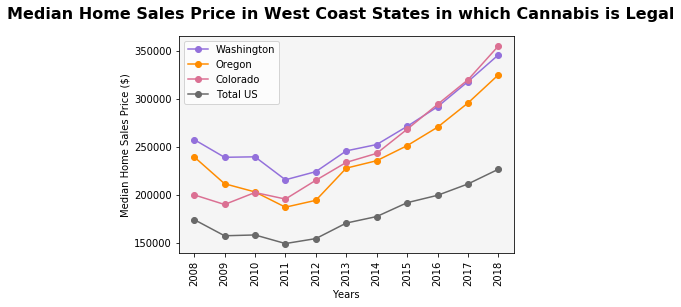

In [55]:
testfig,testax=plt.subplots()
x_axis=us_wa_avg.index.tolist()
# testax2.plot(x_axis,z,marker='o',color='green',label='5 Change in Median Home Sales Price')
testax.plot(x_axis,us_wa_avg['Washington'].dropna(),label='Washington',marker='o',color='mediumpurple')
testax.plot(x_axis,us_wa_avg['Oregon'].dropna(),label='Oregon',marker='o',color='darkorange')
testax.plot(x_axis,us_wa_avg['Colorado'].dropna(),label='Colorado',marker='o',color='palevioletred')
testax.plot(x_axis,us_wa_avg['United States'].dropna(),label='Total US',marker='o',color='dimgrey')

testfig.suptitle("Median Home Sales Price in West Coast States in which Cannabis is Legal", fontsize=16, fontweight="bold")
plt.legend(loc='best')
plt.xlabel("Years")
plt.ylabel("Median Home Sales Price ($)")
plt.xticks(x_axis,rotation='vertical')
testax.set_facecolor('whitesmoke')
plt.show()

In [57]:
us_wa_avg

,Washington,United States,Colorado,Oregon
Year,,,,
2008,258050.0,174650.0,200400.0,240050.0
2009,239550.0,157750.0,190350.0,212000.0
2010,240050.0,158600.0,202850.0,203450.0
2011,216100.0,149650.0,196000.0,187550.0
2012,224600.0,154800.0,215600.0,194700.0
2013,246250.0,171000.0,234250.0,228250.0
2014,252850.0,177800.0,243650.0,236000.0
2015,271800.0,192250.0,268800.0,251700.0
2016,292250.0,199950.0,294750.0,270950.0


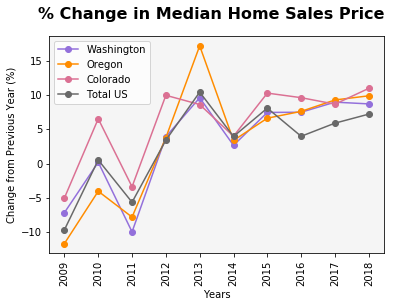

In [59]:
testfig2,testax2=plt.subplots()
x_axis=[2009,2010,2011,2012,2013,2014,2015,2016,2017,2018]
# testax2.plot(x_axis,z,marker='o',color='green',label='5 Change in Median Home Sales Price')
testax2.plot(x_axis,us_wa_avg['WA_Percent_Change'].dropna(),label='Washington',marker='o',color='mediumpurple')
testax2.plot(x_axis,us_wa_avg['OR_Percent_Change'].dropna(),label='Oregon',marker='o',color='darkorange')
testax2.plot(x_axis,us_wa_avg['CO_Percent_Change'].dropna(),label='Colorado',marker='o',color='palevioletred')
testax2.plot(x_axis,us_wa_avg['US_Percent_Change'].dropna(),label='Total US',marker='o',color='dimgrey')

testfig2.suptitle("% Change in Median Home Sales Price", fontsize=16, fontweight="bold")
plt.legend(loc='best')
plt.xlabel("Years")
plt.ylabel("Change from Previous Year (%)")
plt.xticks(x_axis,rotation='vertical')
testax2.set_facecolor('whitesmoke')
plt.show()

# Build Heat Map of Sales in Washington with Retailer Markers

In [60]:
business

,Organization,Active,License,UBI,Type,Address,Address Line 2,City,State,County,Zip,CreateDate,DayPhone
0,BEAUSOLEIL,ACTIVE (ISSUED),416694,6033541680010000,MARIJUANA PRODUCER TIER 3/MARIJUANA PROCESSOR,7903 BEAVER VALLEY RD STE A,NaN,CHIMACUM,WA,JEFFERSON,983250000,20171229,2.253299e+09
1,'OH' MCDONALD FARMS,ACTIVE (ISSUED),413650,6034429790010000,MARIJUANA PRODUCER TIER 2/MARIJUANA PROCESSOR,250 W AXTON RD,NaN,BELLINGHAM,WA,WHATCOM,982267315,20171104,3.609667e+09
2,POT ZONE,ACTIVE (ISSUED),415229,6033538680010000,MARIJUANA RETAILER,1703 SE SEDGWICK RD,STE 113,PORT ORCHARD,WA,KITSAP,983669599,20171114,2.533127e+09
3,BEST BUDS MARKETING AND DISTRIBUTION,ACTIVE (ISSUED),425431,6041333310010000,MARIJUANA TRANSPORTATION,1206 N DOLARWAY RD STE 116,NaN,ELLENSBURG,WA,KITTITAS,989268392,20171115,2.064095e+09
4,RED FROG,ACTIVE (ISSUED),412437,6033472750010000,MARIJUANA PRODUCER TIER 3/MARIJUANA PROCESSOR,12815 227TH AVE SE STE A,STE A,MONROE,WA,SNOHOMISH,982728720,20171130,3.608059e+09
5,BULLDOG WEED,PENDING (ISSUED),412050,6034300560010000,MARIJUANA PRODUCER TIER 2/MARIJUANA PROCESSOR,6009 N JULIA ST,NaN,SPOKANE,WA,SPOKANE,992176584,20180306,5.093896e+09
6,ALTITUDE,ACTIVE (ISSUED),414225,6033570900010000,MARIJUANA RETAILER/MEDICAL MARIJUANA ENDORSEMENT,260 MERLOT DR,NaN,PROSSER,WA,BENTON,993500000,20171114,5.097864e+09
7,INTERSTATE 502,ACTIVE (ISSUED),417580,6033571480010000,MARIJUANA PRODUCER TIER 2/MARIJUANA PROCESSOR,3431 AIRPORT RD STE C,NaN,PULLMAN,WA,WHITMAN,991636001,20180119,2.085966e+09
8,VERDANT CIRCLE,ACTIVE (ISSUED),416880,6033612390010000,MARIJUANA PRODUCER TIER 3/MARIJUANA PROCESSOR,7797 ROAD K.5 NE STE B,STE B,MOSES LAKE,WA,GRANT,988379001,20180105,4.147310e+09
9,SATIVA GROUP,ACTIVE (ISSUED),422627,6033563190010000,MARIJUANA PROCESSOR,7537 POSTMA RD,STE A,MOXEE,WA,YAKIMA,989369806,20171207,5.095711e+09


In [63]:
business.isna().sum()

Organization         0
Active               0
License              0
UBI                  0
Type                 0
Address              0
Address Line 2    1487
City                 0
State                0
County               0
Zip                  0
CreateDate           0
DayPhone             4
dtype: int64

In [67]:
pot_sales

,Trade Name,License Number,UBI,Privilege Code,Period Start,Period End,Total Sales,Excise Tax,Total Due,Status,Submit Date,Fiscal Year
0,AMERICAN HARVEST,422954,603352573,0394 0395,5/1/2016,5/31/2016,0.00,0.00,0.00,Unconfirmed,NaN,2016
1,JBC FARMS,412196,602025531,392,1/1/2016,1/31/2016,0.00,0.00,0.00,Unconfirmed,NaN,2016
2,HONU ENTERPRISES,412097,603341347,393,9/1/2016,9/30/2016,318638.59,0.00,0.00,Confirmed,10/18/2016,2017
3,MILLER'S MARIJUANA,415001,603358103,0394 0395,9/1/2015,9/30/2015,91718.76,33935.94,33935.94,Confirmed,10/19/2015,2016
4,OPTIMIZED PROPOGATION LIMITED LIABILITY COMPA,416425,603356803,393,5/1/2015,5/31/2015,0.00,0.00,0.00,Confirmed,6/16/2015,2015
5,HERBSCAPES,412670,601264180,391,12/1/2014,12/31/2014,4956.00,1239.00,1239.00,Confirmed,1/15/2015,2015
6,AISLING ENTERPRISES,413288,602990684,391,5/1/2016,5/31/2016,1407.00,0.00,0.00,Confirmed,6/20/2016,2016
7,PIONEER PRODUCTION & PROCESSING,416063,603348686,391,11/1/2016,11/30/2016,0.00,0.00,0.00,Confirmed,12/16/2016,2017
8,THE SUNSHINE TIKI HUT,417198,602883407,393,10/1/2016,10/31/2016,23714.25,0.00,0.00,Unconfirmed,NaN,2017
9,BACONS BUDS,412288,603350357,391,3/1/2016,3/31/2016,0.00,0.00,0.00,Confirmed,4/5/2016,2016


In [64]:
retailers=business.loc[(business['Type']=='MARIJUANA RETAILER/MEDICAL MARIJUANA ENDORSEMENT') | (business['Type']=='MARIJUANA RETAILER'),: ]


In [65]:
retailers

,Organization,Active,License,UBI,Type,Address,Address Line 2,City,State,County,Zip,CreateDate,DayPhone
2,POT ZONE,ACTIVE (ISSUED),415229,6033538680010000,MARIJUANA RETAILER,1703 SE SEDGWICK RD,STE 113,PORT ORCHARD,WA,KITSAP,983669599,20171114,2.533127e+09
6,ALTITUDE,ACTIVE (ISSUED),414225,6033570900010000,MARIJUANA RETAILER/MEDICAL MARIJUANA ENDORSEMENT,260 MERLOT DR,NaN,PROSSER,WA,BENTON,993500000,20171114,5.097864e+09
18,DOCKSIDE CANNABIS,ACTIVE (ISSUED),414174,6033563140010000,MARIJUANA RETAILER/MEDICAL MARIJUANA ENDORSEMENT,1728 4TH AVE S,NaN,SEATTLE,WA,KING,981340000,20171214,2.062236e+09
21,FILLABONG,ACTIVE (ISSUED),415211,6035601210010000,MARIJUANA RETAILER/MEDICAL MARIJUANA ENDORSEMENT,2839 NW KITSAP PL STE A,NaN,SILVERDALE,WA,KITSAP,983839447,20171023,3.606980e+09
25,HERBAL NATION,ACTIVE (ISSUED),413683,6034896600010000,MARIJUANA RETAILER/MEDICAL MARIJUANA ENDORSEMENT,19302 BOTHELL EVERETT HWY,NaN,BOTHELL,WA,SNOHOMISH,980127113,20180306,4.254861e+09
32,PRC,ACTIVE (ISSUED),421084,6033210770010000,MARIJUANA RETAILER/MEDICAL MARIJUANA ENDORSEMENT,5200 172ND ST NE F-101,NaN,ARLINGTON,WA,SNOHOMISH,982234703,20171228,4.253432e+09
34,HIGH SOCIETY,ACTIVE (ISSUED),414430,6033510330010000,MARIJUANA RETAILER/MEDICAL MARIJUANA ENDORSEMENT,1824 BROADWAY,NaN,EVERETT,WA,SNOHOMISH,982012349,20180108,2.063072e+09
43,EVERGREEN MARKET - KIRKLAND,ACTIVE (ISSUED),414475,6035653130010000,MARIJUANA RETAILER/MEDICAL MARIJUANA ENDORSEMENT,8734 120TH AVE NE,NaN,KIRKLAND,WA,KING,980335861,20171107,4.253189e+09
51,GREEN COLLAR NORTH,ACTIVE (ISSUED),422570,6033583850010000,MARIJUANA RETAILER/MEDICAL MARIJUANA ENDORSEMENT,21412 HIGHWAY 99 STE A,NaN,EDMONDS,WA,SNOHOMISH,980267748,20171216,3.039578e+09
53,THE GALLERY SPANAWAY,ACTIVE (ISSUED),413420,6033367320010000,MARIJUANA RETAILER/MEDICAL MARIJUANA ENDORSEMENT,21802 MOUNTAIN HWY E STE 1,NaN,SPANAWAY,WA,PIERCE,983870000,20170810,3.052989e+09


In [68]:
retailers['UBI']=retailers.UBI.astype(str).apply(lambda x: x[:9])
retailers['UBI']=retailers['UBI'].astype(int)

C:\Users\mstos\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
C:\Users\mstos\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [9]:
pot_sales=pot_sales.loc[pot_sales['Total Sales'] != 0,:]
pot_sales.dropna(subset=['UBI'],inplace=True)
# pot_sales.head()

In [10]:
ret_sales=retailers.merge(pot_sales,on='UBI',how='inner')

In [11]:
dates=pd.to_datetime(ret_sales['Period Start'],format='%m/%d/%Y')
ret_sales['Sales Month']=dates.apply(lambda x: x.strftime('%Y-%m'))

In [12]:
ret_sales['Zip']=ret_sales['Zip'].astype(str).apply(lambda x: x[:5]).astype(int)

In [13]:
sales_by_city=pd.DataFrame(ret_sales.groupby(['City','State'])['Total Sales'].sum())
sales_by_city.reset_index(inplace=True)

In [14]:
sales_by_city

,City,State,Total Sales
0,ABERDEEN,WA,8.364748e+06
1,AIRWAY HEIGHTS,WA,8.901182e+06
2,ALLYN,WA,1.856155e+06
3,ANACORTES,WA,6.780781e+06
4,ARLINGTON,WA,2.768995e+07
5,AUBURN,WA,3.243790e+07
6,BAINBRIDGE ISLAND,WA,7.995891e+06
7,BATTLE GROUND,WA,6.721034e+06
8,BELFAIR,WA,4.222936e+06
9,BELLEVUE,WA,5.829484e+07


In [15]:
url = "https://maps.googleapis.com/maps/api/geocode/json?address="
lat=[]
lng=[]
for i in range(len(sales_by_city)):
    query_url = url + sales_by_city.iloc[i]['City'] + ",+WA&key=" + gkey
    response = requests.get(query_url)
    json = response.json()
    lat.append(json['results'][0]['geometry']['location']['lat'])
    lng.append(json['results'][0]['geometry']['location']['lng'])

sales_by_city['lat']=lat
sales_by_city['lng']=lng

In [16]:
sales_by_address=pd.DataFrame(ret_sales.groupby(['Address','City','State'])['Total Sales'].sum())
sales_by_address.reset_index(inplace=True)

In [17]:
lat_mark=[]
lng_mark=[]
for i in range(len(sales_by_address)):
    query_url_mark= url + sales_by_address.iloc[i]['Address']+ ",+" + sales_by_address.iloc[i]['City'] + ",+WA&key=" + gkey
    json_mark = requests.get(query_url_mark).json()
    try:
        lat_mark.append(json_mark['results'][0]['geometry']['location']['lat'])
        lng_mark.append(json_mark['results'][0]['geometry']['location']['lng'])
    except: 
        lat_mark.append('none')
        lng_mark.append('none')

sales_by_address['lat']=lat_mark
sales_by_address['lng']=lng_mark

In [18]:
locations_marker=sales_by_address[sales_by_address['lat']!='none']

In [19]:
# Store latitude and longitude in locations
locations = sales_by_city[["lat", "lng"]]
weight=sales_by_city['Total Sales'].astype(float)

heat_layer = gmaps.heatmap_layer(
    locations, weights=weight,dissipating=False,point_radius=0.8)

locations_marker=sales_by_address[sales_by_address['lat']!='none']
locations_marker=locations_marker[['lat','lng']]

marker_layer=gmaps.symbol_layer(locations_marker,fill_color='green',stroke_color='black',scale=2)

fig = gmaps.figure()
fig.add_layer(heat_layer)
fig.add_layer(marker_layer)
fig

Figure(layout=FigureLayout(height='420px'))

# Make Timeseries of Average % Change in Median Home Sales Price in Zip Codes with Marijuana Retailers

In [20]:
wa_all_hp=homeprice.loc[homeprice['StateName']=='Washington',['RegionName','2008-03','2008-04','2008-05','2008-06','2008-07',
 '2008-08','2008-09','2008-10','2008-11','2008-12','2009-01','2009-02','2009-03','2009-04','2009-05','2009-06','2009-07','2009-08',
 '2009-09','2009-10','2009-11','2009-12','2010-01','2010-02','2010-03','2010-04','2010-05','2010-06','2010-07','2010-08','2010-09',
 '2010-10','2010-11','2010-12','2011-01','2011-02','2011-03','2011-04','2011-05','2011-06','2011-07','2011-08','2011-09','2011-10',
 '2011-11','2011-12','2012-01','2012-02','2012-03','2012-04','2012-05','2012-06','2012-07','2012-08','2012-09','2012-10','2012-11',
 '2012-12','2013-01','2013-02','2013-03','2013-04','2013-05','2013-06','2013-07','2013-08','2013-09','2013-10','2013-11','2013-12',
 '2014-01','2014-02','2014-03','2014-04','2014-05','2014-06','2014-07','2014-08','2014-09','2014-10','2014-11','2014-12','2015-01',
 '2015-02','2015-03','2015-04','2015-05','2015-06','2015-07','2015-08','2015-09','2015-10','2015-11','2015-12','2016-01','2016-02',
 '2016-03','2016-04','2016-05','2016-06','2016-07','2016-08','2016-09','2016-10','2016-11','2016-12','2017-01','2017-02','2017-03',
 '2017-04','2017-05','2017-06','2017-07','2017-08','2017-09','2017-10','2017-11','2017-12','2018-01','2018-02','2018-03','2018-04',
 '2018-05','2018-06','2018-07','2018-08','2018-09','2018-10','2018-11']]
wa_all_hp.rename(columns={'RegionName':'Zip_MedianHomeSale'},inplace=True)
wa_all_hp.set_index('Zip_MedianHomeSale',inplace=True)
wa_all_hp=wa_all_hp.transpose()
wa_all_hp.head()

Zip_MedianHomeSale,98052,98012,98103,98682,98133,99208,98122,98208,98034,98109,...,98446,98252,98328,98327,98418,99026,98580,98606,98329,98629
2008-03,431100.0,384900.0,NaN,225100.0,318100.0,208400.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2008-04,429300.0,375100.0,NaN,221700.0,338700.0,213800.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2008-05,419000.0,364300.0,NaN,218100.0,322100.0,207400.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2008-06,412800.0,374900.0,NaN,213700.0,336900.0,202900.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2008-07,413100.0,368100.0,NaN,216400.0,332500.0,199500.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [21]:
mj_sales_zip=pd.crosstab(ret_sales['Zip'],ret_sales['Sales Month'],values=ret_sales['Total Sales'],aggfunc=np.sum).transpose()
# mj_sales_zip=pd.crosstab(ret_sales['Zip'],ret_sales['Sales Month'],values=ret_sales['Total Sales'],aggfunc=np.sum)
mj_sales_zip.head()

Zip,94140,98002,98003,98004,98005,98006,98007,98012,98020,98021,...,99223,99224,99336,99337,99344,99350,99352,99354,99362,99403
Sales Month,,,,,,,,,,,,,,,,,,,,,
2014-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,129982.22,NaN,NaN,NaN,NaN
2014-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,220661.44,NaN,NaN,NaN,NaN
2014-09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,186974.66,NaN,NaN,NaN,NaN
2014-10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,186469.59,NaN,NaN,NaN,NaN
2014-11,NaN,15761.4,NaN,NaN,106287.31,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,208680.10,NaN,NaN,NaN,NaN


In [22]:
all_data=mj_sales_zip.join(wa_all_hp,how='outer',lsuffix='_mjsales',rsuffix='_homeprice')
all_data

,94140,98002_mjsales,98003_mjsales,98004_mjsales,98005,98006_mjsales,98007,98012_mjsales,98020_mjsales,98021_mjsales,...,98446,98252_homeprice,98328,98327,98418,99026_homeprice,98580,98606,98329_homeprice,98629
2008-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2008-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2008-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2008-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2008-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2008-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2008-09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2008-10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2008-11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2008-12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [23]:
df=all_data.filter(like='_',axis=1)
df

,98002_mjsales,98003_mjsales,98004_mjsales,98006_mjsales,98012_mjsales,98020_mjsales,98021_mjsales,98026_mjsales,98027_mjsales,98028_mjsales,...,98408_homeprice,98057_homeprice,98663_homeprice,98660_homeprice,98321_homeprice,99218_homeprice,98424_homeprice,98252_homeprice,99026_homeprice,98329_homeprice
2008-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,205800.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2008-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,198500.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2008-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,188100.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2008-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,187100.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2008-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,187300.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2008-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,188800.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2008-09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,182100.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2008-10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,181900.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2008-11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,171900.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2008-12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,164900.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [24]:
zipcodes_with_mj=df.filter(like='homeprice',axis=1)
zipcodes_with_mj

,98052_homeprice,98012_homeprice,98103_homeprice,98682_homeprice,98133_homeprice,99208_homeprice,98122_homeprice,98208_homeprice,98034_homeprice,98109_homeprice,...,98408_homeprice,98057_homeprice,98663_homeprice,98660_homeprice,98321_homeprice,99218_homeprice,98424_homeprice,98252_homeprice,99026_homeprice,98329_homeprice
2008-03,431100.0,384900.0,NaN,225100.0,318100.0,208400.0,NaN,NaN,NaN,NaN,...,205800.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2008-04,429300.0,375100.0,NaN,221700.0,338700.0,213800.0,NaN,NaN,NaN,NaN,...,198500.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2008-05,419000.0,364300.0,NaN,218100.0,322100.0,207400.0,NaN,NaN,NaN,NaN,...,188100.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2008-06,412800.0,374900.0,NaN,213700.0,336900.0,202900.0,NaN,NaN,NaN,NaN,...,187100.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2008-07,413100.0,368100.0,NaN,216400.0,332500.0,199500.0,NaN,NaN,NaN,NaN,...,187300.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2008-08,454500.0,372600.0,NaN,210600.0,324300.0,201700.0,NaN,NaN,NaN,NaN,...,188800.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2008-09,466400.0,362700.0,NaN,209600.0,321500.0,192100.0,NaN,NaN,NaN,NaN,...,182100.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2008-10,452400.0,372000.0,NaN,202700.0,316600.0,198800.0,NaN,NaN,NaN,NaN,...,181900.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2008-11,434000.0,357300.0,NaN,202000.0,319400.0,203900.0,NaN,NaN,NaN,NaN,...,171900.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2008-12,421900.0,363400.0,NaN,199900.0,319600.0,212100.0,NaN,NaN,NaN,NaN,...,164900.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [25]:
list1=list(zipcodes_with_mj)
zipcodes_with_mj.reset_index(inplace=True)
zipcodes_with_mj[['Year','Month']]=zipcodes_with_mj['index'].str.split('-',expand=True)

C:\Users\mstos\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\frame.py:3140: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]


In [26]:
zipcodes_with_mj.groupby('Year')['{0}'.format('98103_homeprice')].mean()

Year
2008              NaN
2009    402266.666667
2010    431958.333333
2011    396241.666667
2012    405991.666667
2013    455975.000000
2014    466650.000000
2015    519300.000000
2016    589658.333333
2017    673716.666667
2018    775972.727273
Name: 98103_homeprice, dtype: float64

In [27]:
yearavg=pd.DataFrame(index=['2008','2009','2010','2011','2012','2013','2014','2015','2016','2017','2018'])

In [28]:

for i in list1:
    yearavg=yearavg.join(zipcodes_with_mj.groupby('Year')['{0}'.format(i)].median(),how='outer')

In [29]:
yearavg

,98052_homeprice,98012_homeprice,98103_homeprice,98682_homeprice,98133_homeprice,99208_homeprice,98122_homeprice,98208_homeprice,98034_homeprice,98109_homeprice,...,98408_homeprice,98057_homeprice,98663_homeprice,98660_homeprice,98321_homeprice,99218_homeprice,98424_homeprice,98252_homeprice,99026_homeprice,98329_homeprice
2008,430200.0,370050.0,NaN,212150.0,321800.0,203400.0,NaN,NaN,NaN,NaN,...,187200.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2009,411200.0,336300.0,401000.0,185950.0,302200.0,191750.0,NaN,NaN,NaN,NaN,...,158300.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010,402950.0,317500.0,434200.0,178700.0,293450.0,185350.0,NaN,NaN,NaN,NaN,...,142350.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011,402550.0,284500.0,399550.0,156300.0,263900.0,171300.0,NaN,NaN,NaN,NaN,...,116200.0,NaN,NaN,NaN,NaN,209050.0,NaN,NaN,NaN,199200.0
2012,408250.0,302550.0,407900.0,161400.0,276000.0,179300.0,NaN,NaN,NaN,NaN,...,110400.0,NaN,NaN,160650.0,227400.0,188350.0,NaN,NaN,NaN,227500.0
2013,443150.0,345200.0,457050.0,185150.0,313500.0,177950.0,426800.0,NaN,NaN,NaN,...,135150.0,NaN,NaN,180250.0,239500.0,196650.0,NaN,NaN,NaN,220450.0
2014,471250.0,361800.0,458550.0,207050.0,327600.0,182600.0,422600.0,NaN,NaN,NaN,...,141450.0,NaN,209100.0,212800.0,236850.0,199750.0,NaN,217800.0,NaN,204950.0
2015,498850.0,393500.0,536800.0,225200.0,359350.0,202400.0,473000.0,NaN,396800.0,NaN,...,156250.0,NaN,218100.0,219900.0,294450.0,211700.0,NaN,226700.0,244700.0,232100.0
2016,567900.0,434900.0,592550.0,254050.0,417250.0,217300.0,546400.0,372200.0,443750.0,492500.0,...,184550.0,304400.0,232100.0,241550.0,297950.0,214500.0,282900.0,247950.0,249600.0,275050.0
2017,680700.0,499350.0,663000.0,281550.0,503300.0,225850.0,653900.0,400900.0,520000.0,600100.0,...,216650.0,328700.0,268250.0,250750.0,339900.0,241150.0,302300.0,278200.0,271800.0,303100.0


In [30]:
yearavgchange=pd.DataFrame(index=['2008','2009','2010','2011','2012','2013','2014','2015','2016','2017','2018'])
for col in yearavg:
    yearavgchange=yearavgchange.join(yearavg['{0}'.format(col)].pct_change()*100,how='outer',rsuffix='_pctchange')

In [31]:
yearavgchange.mean(axis=1)

2008          NaN
2009    -8.087400
2010    -2.547293
2011   -11.845074
2012     2.528901
2013    11.476951
2014     6.304635
2015     9.631026
2016    12.462583
2017    13.353311
2018    12.045931
dtype: float64

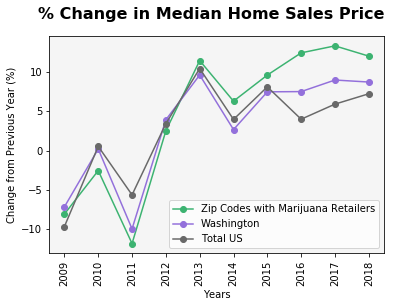

In [32]:
testfig3,testax3=plt.subplots()
x_axis=[2009,2010,2011,2012,2013,2014,2015,2016,2017,2018]
# testax2.plot(x_axis,z,marker='o',color='green',label='5 Change in Median Home Sales Price')
testax3.plot(x_axis,yearavgchange.mean(axis=1).dropna(),label='Zip Codes with Marijuana Retailers',marker='o',color='mediumseagreen')
testax3.plot(x_axis,us_wa_avg['WA_Percent_Change'].dropna(),label='Washington',marker='o',color='mediumpurple')
testax3.plot(x_axis,us_wa_avg['US_Percent_Change'].dropna(),label='Total US',marker='o',color='dimgrey')

testfig3.suptitle("% Change in Median Home Sales Price", fontsize=16, fontweight="bold")
plt.legend(loc='best')
plt.xlabel("Years")
plt.ylabel("Change from Previous Year (%)")
plt.xticks(x_axis,rotation='vertical')
testax3.set_facecolor('whitesmoke')
plt.show()